Link to GitHub:

https://github.com/YuetongLiu/Hate_Speech_and_Offensive_Language

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import *
import string
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim.models.word2vec import Word2Vec
import warnings
from random import choice
from gensim import corpora, models
from gensim.models import CoherenceModel
import csv
from liwc import LIWC
warnings.filterwarnings("ignore")

# Load Raw Data

In [3]:
df=pd.read_csv("labeled_data.csv")
df.drop(df.columns[[0]], axis=1,inplace=True)
print(df.iloc[:5,:])
print(df.shape)

   count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...  
(24783, 6)


# Data Pre-processing 

In [4]:
df['tweet'][:20]

0     !!! RT @mayasolovely: As a woman you shouldn't...
1     !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2     !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3     !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4     !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5     !!!!!!!!!!!!!!!!!!"@T_Madison_x: The shit just...
6     !!!!!!"@__BrighterDays: I can not just sit up ...
7     !!!!&#8220;@selfiequeenbri: cause I'm tired of...
8     " &amp; you might not get ya bitch back &amp; ...
9     " @rhythmixx_ :hobbies include: fighting Maria...
10    " Keeks is a bitch she curves everyone " lol I...
11                   " Murda Gang bitch its Gang Land "
12    " So hoes that smoke are losers ? " yea ... go...
13        " bad bitches is the only thing that i like "
14                              " bitch get up off me "
15                      " bitch nigga miss me with it "
16                               " bitch plz whatever "
17                            " bitch who do you

In [5]:
# Index of tweet only contain format like"#XX #XX" (which would be empty after remove hashtag)
# We need to specially deal with them
special_index=[804,826,846,848,849,923,1016,1122,1909,3398,4818,5711,6098,6279,6332,6668,7168,11951,15859,18062]
# for example
print(df['tweet'][804])

#Yankees


In [6]:
# Also there are two meaningless tweet
print(df['tweet'][4828])
print(df['tweet'][6098])
meaningless_index=[4828,6098]

@TNKidsFoodPorn @Oreo ..............&#128530;
@hoes &#9829;


In [7]:
#copy original text
txt=df.iloc[:,4:6]
tweet=txt.iloc[:,1].copy(deep=True)
stemmer = PorterStemmer()

In [8]:
def preprocess(tweet_,specail_index,meaningless_index):
    #remove stopwords
    stopwords = nltk.corpus.stopwords.words("english")
    other = ["#ff", "ff", "rt"]
    stopwords.extend(other)
    #word tokenize and remove stopwords
    
    for i in range(tweet_.shape[0]):
        text=tweet_[i].lower()
        text1=''.join([word+" " for word in text.split() if word not in stopwords])
        tweet_[i]=text1
    
    #remove digit and excessive whitespace
    #remove url mention and hashtag
    
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    
    for i in range(tweet_.shape[0]):
        text_string=tweet_[i]
        parsed_text = re.sub(space_pattern, ' ', text_string)
        parsed_text = re.sub(giant_url_regex, '', parsed_text)
        parsed_text = re.sub(mention_regex, '', parsed_text) 
        if i not in specail_index:
            parsed_text = re.sub(hashtag_regex, '', parsed_text)
        else:
            parsed_text = re.sub('#','',parsed_text)
        if i in meaningless_index:
            parsed_text ='This is a simple tweet'
        tweet_[i]=parsed_text
    
    #tokenize and stemming
    """Removes punctuation and stems tweets. Returns a list of stemmed tokens."""
    for i in range(tweet_.shape[0]):
        tweet_stem=tweet_[i]
        tweet_stem = " ".join(re.split("[^a-zA-Z]*", tweet_stem)).strip()
        tweet_process = [stemmer.stem(t) for t in tweet_stem.split()]
        tweet_[i]=tweet_process
        
    return tweet_

## Results of pre-processing:

In [9]:
#results of pre-process
tweet=preprocess(tweet,special_index,meaningless_index)
print(tweet[:20])

0     [w, o, m, a, n, c, o, m, p, l, a, i, n, c, l, ...
1     [b, o, y, d, a, t, s, c, o, l, d, t, y, g, a, ...
2     [d, a, w, g, e, v, e, r, f, u, c, k, b, i, t, ...
3            [l, o, o, k, l, i, k, e, t, r, a, n, n, y]
4     [s, h, i, t, h, e, a, r, m, i, g, h, t, t, r, ...
5     [s, h, i, t, b, l, o, w, s, m, e, c, l, a, i, ...
6     [s, i, t, h, a, t, e, a, n, o, t, h, e, r, b, ...
7     [c, a, u, s, e, i, m, t, i, r, e, d, b, i, g, ...
8     [a, m, p, m, i, g, h, t, g, e, t, y, a, b, i, ...
9     [h, o, b, b, i, e, s, i, n, c, l, u, d, e, f, ...
10    [k, e, e, k, s, b, i, t, c, h, c, u, r, v, e, ...
11    [m, u, r, d, a, g, a, n, g, b, i, t, c, h, g, ...
12    [h, o, e, s, s, m, o, k, e, l, o, s, e, r, s, ...
13    [b, a, d, b, i, t, c, h, e, s, t, h, i, n, g, ...
14                             [b, i, t, c, h, g, e, t]
15           [b, i, t, c, h, n, i, g, g, a, m, i, s, s]
16     [b, i, t, c, h, p, l, z, w, h, a, t, e, v, e, r]
17                          [b, i, t, c, h, l, o

In [25]:
tweet = pd.DataFrame(tweet)
tweet.to_csv("../data/clean.csv", index = False)

# Feature Extraction
## 1.LIWC

In [245]:
#run LIWC on the whole df

LIWC_list=[]
for i in range(len(tweet)):
    L = LIWC()
    length, matched, labels = L.classify(tweet[i])
    LIWC_list.append(L.readable(labels))
LIWC_list
#update preprocessed text to original df
df.tweet=tweet
hateSpeech=df[df['hate_speech'] ==3]["tweet"].reset_index(drop=True)
#it is the list of hate speech
LIWC_list1=[]
for i in range(len(hateSpeech)):
    L = LIWC()
    length, matched, labels = L.classify(hateSpeech[i])
    LIWC_list1.append(L.readable(labels))
LIWC_list1
#function that add dictionary
def mergeDict(dict1, dict2):
   ''' Merge dictionaries and keep values of common keys in list'''
   dict3 = {**dict1, **dict2}
   for key, value in dict3.items():
       if key in dict1 and key in dict2:
               dict3[key] = value +dict1[key]
   return dict3
#add those dic together
hate_dic=LIWC_list1[0]
for i in range(len(LIWC_list1)):
    hate_dic=mergeDict(hate_dic, LIWC_list1[i])
hate_dic.keys()
#find hate_relevent key by analyzing hate speech
relevent_key=[k for k, v in hate_dic.items() if v > 50]
#build dataframe with relevent columns
LIWC_df=pd.DataFrame(data=LIWC_list, index=None, columns=None, dtype=None, copy=False)[relevent_key]
LIWC_df.shape

(24783, 20)

In [ ]:
LIWC_df = LIWC_df.fillna(0)
LIWC_df.to_csv("../data/LIWC.csv", index = False)

## 2.Skip-gram

Average len of tweet（after preprocessing)

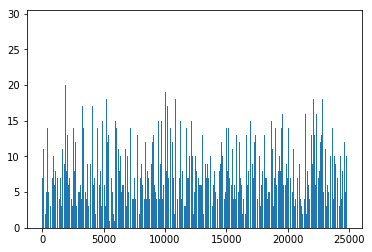

7.962191825041359


In [228]:
#average len of tweet
avg=0
num=[]
x=[x for x in range(24783)]
for n in range(tweet.shape[0]):
    avg+=len(tweet[n])
    num.append(len(tweet[n]))
avg=avg/(tweet.shape[0])
plt.bar(x,num)
plt.show()
print(avg)

In [229]:
#check the input data for word2vec
len(tweet)

24783

Split Train and Test data

In [230]:
#combine tweet data with labels
tweet_pd=pd.DataFrame(tweet)
tweet_pd['label']=txt.iloc[:,0]
tweet_train, tweet_test = train_test_split(tweet_pd, test_size = 0.1)
print("size of train data/test data:",len(tweet_train),len(tweet_test))

size of train data/test data: 22304 2479


In [232]:
#input data for word2vec
tweet_skip_train=np.array(tweet_train.iloc[:,0])
tweet_skip_train[:3]

array([list(['lookin', 'like', 'total', 'swag', 'fag', 'ayeee']),
       list(['dumb', 'bitch', 'think', 'buddha', 'say', 'namast']),
       list(['littl', 'girl', 'tom', 'sawyer', 'get', 'trap', 'cave', 'along', 'injun', 'joe', 'almost', 'die', 'injun', 'joe', 'die', 'find', 'treasur'])],
      dtype=object)

word2vec by skip-gram

In [233]:
model = Word2Vec(size=100,min_count=1, workers=5,sg=1)  #dimension is 200, consider 5 words, using skip-gram
model.build_vocab(tweet_skip_train)
model.train(tweet_skip_train,total_examples = model.corpus_count,epochs = 50)

(7495649, 8881500)

In [243]:
#warnings.filterwarnings("ignore")
word_vec=[]
v_in_dic=[]
#average each word vector to get the vector of a single tweet
for i in range(len(tweet_skip_train)):
    sum1=0
    for w in tweet[i]:
        try:
            sum1+=model[w]
            v_in_dic.append(w)
        #for out of dictionary vocab use random select in vocabulary word method to generate vectors
        except:
            random_w=choice(v_in_dic)
            sum1+=model[random_w]
            continue
    avg=sum1/(len(tweet_skip_train))
    avg=list(avg)
    word_vec.append(avg)
word_vec[:5]     

[[-0.0002455775,
  -0.00010290334,
  -9.455103e-05,
  3.963332e-06,
  5.2362535e-05,
  3.980416e-05,
  5.598349e-05,
  -6.0099024e-05,
  1.7975635e-05,
  -0.00014565686,
  -9.094328e-07,
  -0.00015325441,
  5.448408e-05,
  5.374993e-06,
  0.00025168236,
  0.00022321993,
  -0.00018444816,
  0.00017892222,
  -5.6383375e-05,
  0.00014914338,
  0.00021370202,
  3.5252888e-05,
  0.00011195126,
  -0.00024017766,
  -5.0911544e-06,
  -6.052378e-05,
  -0.00014493492,
  -6.3383646e-05,
  1.1499464e-05,
  -3.552594e-05,
  2.4260054e-05,
  -3.576226e-05,
  -5.09649e-05,
  -4.251635e-05,
  -7.214511e-05,
  -0.00012298982,
  9.340326e-05,
  -6.378733e-05,
  0.00012263168,
  9.568141e-05,
  -4.666297e-05,
  2.656023e-05,
  -0.00010233384,
  5.5133703e-05,
  -1.9455596e-05,
  -0.00020622875,
  -5.822185e-06,
  -0.00010365904,
  8.953905e-05,
  -8.617407e-05,
  -0.00018845864,
  -2.1345024e-05,
  3.060512e-05,
  0.00015905123,
  -8.557661e-05,
  5.6494027e-06,
  0.0001139814,
  -0.00019954296,
  -7.255

In [244]:
len(word_vec)

22304

Organize the format of the output vector

In [247]:
word_vec_array=np.array(word_vec)
word_vec_l=np.reshape(word_vec_array[0],(1,100))
for i in range(len(tweet_skip_train)):
    array=np.reshape(word_vec_array[i],(1,100))
    word_vec_l=np.r_[word_vec_l,array]
print(word_vec_l)
word_vec_lt=word_vec_l
word_vec_lt=np.delete(word_vec_lt,0,0)
print(word_vec_lt.shape)

[[-2.45577510e-04 -1.02903337e-04 -9.45510328e-05 ...  9.36346623e-05
  -5.74652149e-05 -5.40808905e-05]
 [-2.45577510e-04 -1.02903337e-04 -9.45510328e-05 ...  9.36346623e-05
  -5.74652149e-05 -5.40808905e-05]
 [-2.77962041e-04 -1.85187571e-04 -6.10788411e-05 ...  1.05673134e-04
   5.72804965e-05 -1.56113689e-04]
 ...
 [-1.46974504e-04 -2.01315153e-04 -1.18379303e-05 ...  4.20343385e-05
   5.39088724e-05 -8.86278867e-05]
 [-5.85618836e-05 -5.30057987e-05  3.16777405e-05 ... -3.86834399e-05
  -2.01089224e-05 -1.92975094e-05]
 [-1.71049294e-04 -3.22787615e-04  2.14753491e-05 ... -8.70875665e-05
   1.90298726e-06 -9.18894002e-05]]
(22304, 100)


Construct test vector

In [ ]:
tweet_skip_test=np.array(tweet_test.iloc[:,0])
#average each word vector to get the vector of a single tweet
for i in range(len(tweet_test)):
    sum1=0
    for w in tweet[i]:
        try:
            sum1+=model[w]
            v_in_dic.append(w)
        #for out of dictionary vocab use random select in vocabulary word method to generate vectors
        except:
            random_w=choice(v_in_dic)
            sum1+=model[random_w]
            continue
    avg=sum1/(len(tweet_skip_train))
    avg=list(avg)
    word_vec.append(avg)

Correlation between featurs

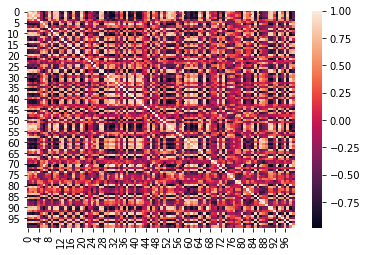

In [15]:
import seaborn as sns
word_vec_lt_p=pd.DataFrame(word_vec_lt)
sns.heatmap(word_vec_lt_p.corr())
plt.show()

In [16]:
word_vec_lt_p.corr

<bound method DataFrame.corr of              0         1         2         3         4         5         6   \
0     -0.378187 -0.341424 -0.219387 -0.421023 -0.032073  0.009670  0.659005   
1     -0.335366 -0.308427 -0.197721 -0.406894 -0.042513  0.032830  0.629779   
2     -0.338344 -0.374144 -0.289829 -0.490306 -0.051115 -0.000127  0.748339   
3     -0.335833 -0.213152 -0.194488 -0.307188 -0.043572  0.012894  0.517207   
4     -0.367412 -0.379855 -0.312911 -0.511126 -0.070462  0.003748  0.815208   
...         ...       ...       ...       ...       ...       ...       ...   
24778 -0.240287 -0.225102 -0.134457 -0.277045 -0.007022 -0.011368  0.398366   
24779 -0.425372 -0.385249 -0.281467 -0.527872 -0.047862  0.038721  0.842835   
24780 -0.483985 -0.385763 -0.285643 -0.567296 -0.082789  0.070580  0.908190   
24781 -0.319147 -0.295356 -0.229092 -0.336418 -0.082757 -0.004183  0.652227   
24782 -0.244060 -0.222693 -0.096786 -0.257059  0.006078 -0.013598  0.321849   

             7     

In [13]:
#save this array as csv

f = open('../data/word2vec_skip.csv', 'w')
a = csv.writer(f)
a.writerows(word_vec_lt)
f.close()

In [14]:
np.savetxt('../data/word2vec_skip1.csv', word_vec_lt, delimiter = ',')  

## 3.LDA

construct dic for LDA 

In [242]:
dictionary = corpora.Dictionary(tweet)
corpus = [dictionary.doc2bow(words) for words in tweet]

Find the optimal topic numbers

In [101]:
for i in [50, 60, 70, 80]:
    lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=i)
    coherence_model_lda = CoherenceModel(model=lda, texts=tweet, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)
    


Coherence Score:  0.38819085916417634

Coherence Score:  0.42194391540606735

Coherence Score:  0.43920979717599234

Coherence Score:  0.41266646537218143


In [102]:
# lda model, num_topics is the number of topic
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=70)
# print 5 words for each topic 
for topic in lda.print_topics(num_words=5):
    print(topic)
# topic infer
lda_infer= lda.inference(corpus)
print(lda.inference(corpus))

(64, '0.200*"man" + 0.074*"show" + 0.043*"eveyhing" + 0.039*"bich" + 0.028*"one"')
(68, '0.147*"n" + 0.121*"us" + 0.066*"wo" + 0.047*"done" + 0.043*"bae"')
(55, '0.165*"alk" + 0.130*"bou" + 0.033*"kid" + 0.029*"youve" + 0.027*"bich"')
(30, '0.122*"bee" + 0.108*"yellow" + 0.067*"bich" + 0.056*"ied" + 0.043*"ask"')
(23, '0.134*"fa" + 0.128*"new" + 0.077*"bich" + 0.063*"die" + 0.046*"ype"')
(13, '0.108*"geing" + 0.088*"black" + 0.072*"nohing" + 0.057*"h" + 0.051*"kids"')
(67, '0.141*"gil" + 0.103*"call" + 0.087*"wie" + 0.044*"like" + 0.042*"days"')
(10, '0.087*"sa" + 0.063*"song" + 0.061*"had" + 0.047*"sick" + 0.047*"pussies"')
(37, '0.118*"gonna" + 0.056*"fee" + 0.043*"im" + 0.043*"use" + 0.037*"somebody"')
(3, '0.113*"lile" + 0.110*"bich" + 0.096*"always" + 0.043*"wish" + 0.043*"hai"')
(39, '0.077*"hi" + 0.068*"niggah" + 0.064*"gon" + 0.064*"onigh" + 0.062*"back"')
(11, '0.107*"alking" + 0.079*"well" + 0.074*"side" + 0.041*"ges" + 0.037*"calling"')
(8, '0.146*"look" + 0.116*"like" + 0.0

In [103]:
print(lda_infer[0].shape)

(24783, 70)


In [104]:
lda_infer = pd.DataFrame(lda_infer[0])
lda_infer.to_csv("../data/lda_infer.csv", index = False)